# Fitting H2O and Silicate areas from unexposed MIs (looping)
- This notebook shows how to quantify the relative area of the silicate peak and H2O peak from acquisitions of olivine-hosted melt inclusions still at depth in the crystal. Specifically, the code unmixes the olivine and melt inclusions spectra to obtain the glass spectra
- In this example, we loop through multiple files, as we find we can use the same peak parameters for all of them
- If you want an example where you manually loop through files, see the exapmle 'H2O_Fitting_MI_ManualLoop'

## Import necessary python things

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
pf.__version__

'1.0.3'

In [2]:
# This is where you tell the code where your spectra are. E.g. DayFolder is the overal folder, if you have subfolders for Spectra and MetaData
import os
DayFolder=os.getcwd()
meta_path=DayFolder +  '\MetaData'
spectra_path=DayFolder + '\Spectra'
file_ext='.txt'
filetype='Witec_ASCII'

In [3]:
# Get the files which are the melt inclusion/H2O acquisitoin first. You need a unique string (here H2O) which is in all files
MI_Files=pf.get_files(path=spectra_path,
file_ext=file_ext, ID_str='H2O', 
exclude_str=['depth', 'line', 'scan'], sort=False)
MI_Files

['02 CC14_MI2_H2O_96mw.txt',
 '05 CC13_MI4_H2O.txt',
 '09 CC9_MI3_H2O.txt',
 '12 CC9_MI1_H2O_20X.txt',
 '15 CC9_MI1_H2O_50X.txt',
 '18 CC5_MI1_H2O_10mw.txt',
 '21 CC7_MI3_H2O.txt',
 '24 CC4_MI1_H2O.txt',
 '29 MS13_2_MI1_H2O.txt']

In [4]:
# These are the files for the acquisition in the neighbouring host mineral - in this case, the unique file string is 'Ol'
Host_Files=pf.get_files(path=spectra_path,
file_ext=file_ext, ID_str='Ol',
exclude_str=['depth', 'line', 'scan'], sort=False)
Host_Files

['03 CC14_MI2_Ol_96mw.txt',
 '06 CC13_MI4_Ol.txt',
 '10 CC9_MI3_Ol.txt',
 '16 CC9_MI1_Ol_50X.txt',
 '19 CC5_MI1_Ol.txt',
 '22 CC7_MI3_Ol.txt',
 '25 CC4_MI1_Ol.txt',
 '30 MS13_2_MI1_Ol.txt']

### Now we want to split up the name into its key parts - this will allow us to match a given melt inclusion file to the host olivine file


In [5]:
char_crystal='_' # This is what you separated your string based on, e.g. here we use underscores
print(Host_Files[0].split(char_crystal))

['03 CC14', 'MI2', 'Ol', '96mw.txt']


In [6]:
# Here you define what characters separate MI and crystal names. First, we are looking at the files of our host olivine. 
pos_crystal=0 # This is which character is the crystal name, e.g. ignoring the prefix, the crystal in the above example is CC14
pos_MI=1 # This is the unique melt inclusion, in the example above this is MI2, which is the second position in the array (so 1 in python which starts counting at zero)
char_MI='_' # If you split your MI using a different string
Host_Files_extract=pf.extract_xstal_MI_name(files=Host_Files, prefix=True, str_prefix=' ',
char_xstal=char_crystal, pos_xstal=pos_crystal, char_MI=char_MI, pos_MI=pos_MI, file_ext=file_ext)
Host_Files_extract.head()

good job, no duplicate file names


,filename,crystal_name,MI_name
0,03 CC14_MI2_Ol_96mw.txt,CC14,MI2
1,06 CC13_MI4_Ol.txt,CC13,MI4
2,10 CC9_MI3_Ol.txt,CC9,MI3
3,16 CC9_MI1_Ol_50X.txt,CC9,MI1
4,19 CC5_MI1_Ol.txt,CC5,MI1


In [7]:
# Now do the same for your melt inclusion files
print(MI_Files[0].split('_'))

['02 CC14', 'MI2', 'H2O', '96mw.txt']


In [8]:
MI_Files_extract=pf.extract_xstal_MI_name(files=MI_Files,prefix=True, str_prefix=' ',
char_xstal=char_crystal, pos_xstal=pos_crystal, char_MI=char_MI, pos_MI=pos_MI)
MI_Files_extract.head()

good job, no duplicate file names


,filename,crystal_name,MI_name
0,02 CC14_MI2_H2O_96mw.txt,CC14,MI2
1,05 CC13_MI4_H2O.txt,CC13,MI4
2,09 CC9_MI3_H2O.txt,CC9,MI3
3,12 CC9_MI1_H2O_20X.txt,CC9,MI1
4,15 CC9_MI1_H2O_50X.txt,CC9,MI1


In [9]:
# This aligns the H2O and silicate file based on the same value for the column xstal name and MI name
merge=MI_Files_extract.merge(Host_Files_extract, on=['crystal_name', 'MI_name' ], how='inner')
merge.head()

,filename_x,crystal_name,MI_name,filename_y
0,02 CC14_MI2_H2O_96mw.txt,CC14,MI2,03 CC14_MI2_Ol_96mw.txt
1,05 CC13_MI4_H2O.txt,CC13,MI4,06 CC13_MI4_Ol.txt
2,09 CC9_MI3_H2O.txt,CC9,MI3,10 CC9_MI3_Ol.txt
3,12 CC9_MI1_H2O_20X.txt,CC9,MI1,16 CC9_MI1_Ol_50X.txt
4,15 CC9_MI1_H2O_50X.txt,CC9,MI1,16 CC9_MI1_Ol_50X.txt


### Select file
- select a file to tweak fit parameters

In [10]:
# Just choose 1 file to have a look
i=0
filename_MI=merge['filename_x'].iloc[i]
filename_Host=merge['filename_y'].iloc[i]
print(merge['filename_y'].iloc[i])

03 CC14_MI2_Ol_96mw.txt


In [11]:
# This pulls out the host file and the MI file
spectra_Host=pf.get_data(path=spectra_path, filename=filename_Host,
            Diad_files=None, filetype=filetype)

spectra_MI=pf.get_data(path=spectra_path, filename=filename_MI,
            Diad_files=None, filetype=filetype)

## First plot spectra

Text(0, 0.5, 'Intensity')

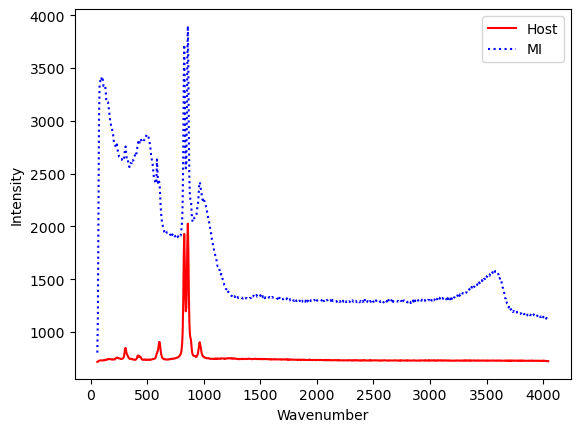

In [12]:
plt.plot(spectra_Host[:, 0], spectra_Host[:,1], '-r', label='Host')
plt.plot(spectra_MI[:, 0], spectra_MI[:,1], ':b', label='MI')
plt.legend()
plt.xlabel('Wavenumber')
plt.ylabel('Intensity')

### Now, lets smooth and trim the spectra, and find the peaks

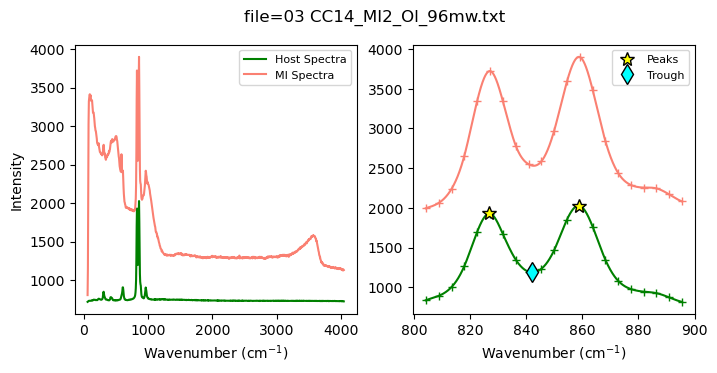

In [13]:
x_new, y_cub_MI, y_cub_Host, peak_pos_Host, peak_height_Host, trough_x, trough_y, fig=pf.smooth_and_trim_around_host(
x_range=[800,900], x_max=900, Host_spectra=spectra_Host,
MI_spectra=spectra_MI, filename=filename_Host)
fig.savefig('smooth_Spline.png', dpi=300, bbox_inches='tight')

## Now lets look at different mixing proportions

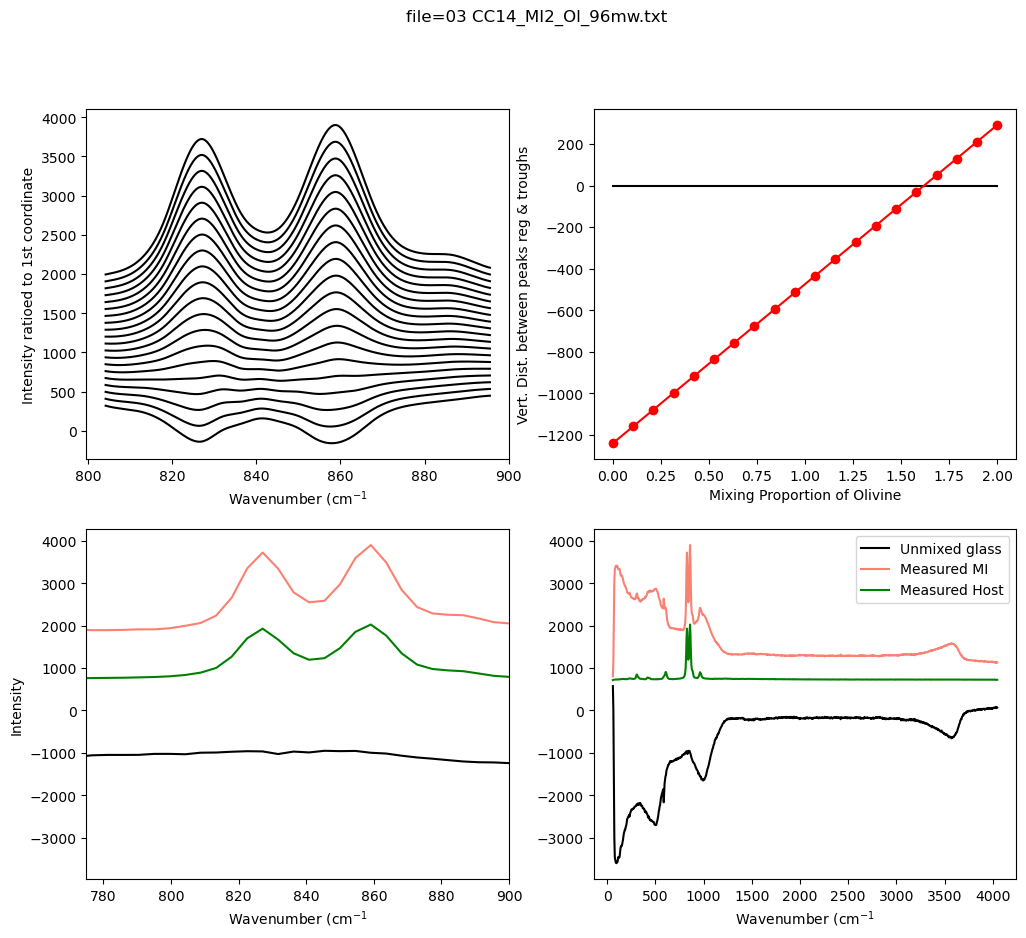

In [14]:
MI_Mix_Best, ideal_mix, Dist, MI_Mix, X=pf.make_evaluate_mixed_spectra(
path=spectra_path, filename=filename_Host,
smoothed_host_y=y_cub_Host, smoothed_MI_y=y_cub_MI,
Host_spectra=spectra_Host, MI_spectra=spectra_MI, x_new=x_new, 
peak_pos_Host= peak_pos_Host,
trough_x=trough_x, trough_y=trough_y, N_steps=20, av_width=2,
X_min=0, X_max=2)

### check if spectra needs inverting
- Sometimes the best fit spectra will end up upsideown, this inverts it if this happens

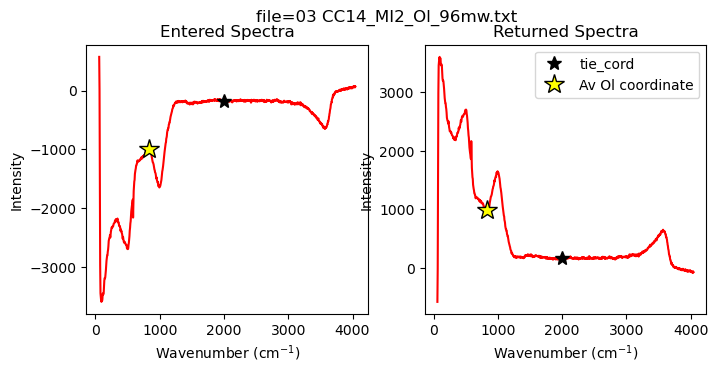

In [15]:
Spectra2=pf.check_if_spectra_negative(Spectra=MI_Mix_Best, 
path=spectra_path, filename=filename_Host,
peak_pos_Host=peak_pos_Host, tie_x_cord=2000, override=False, flip=True)

## Now lets quantify the area under the silicate region

- Set up the background postiions, can overwrite default

In [16]:
config_silicate=pf.sil_bck_pos_Schiavi_basalt(
lower_range_sil=(200, 320),
mid_range1_sil=(640, 670), mid_range2_sil=(800, 860),
upper_range_sil=(1200, 1300),
N_poly_sil=5)

sil_bck_pos_Schiavi_basalt(lower_range_sil=(200, 320), mid_range1_sil=(640, 670), mid_range2_sil=(800, 860), upper_range_sil=(1200, 1300), LW=(400, 600), HW=(800, 1200), N_poly_sil=5, sigma_sil=5)


,Silicate_LHS_Back1,Silicate_LHS_Back2,Silicate_RHS_Back1,Silicate_RHS_Back2,Silicate_N_Poly,Silicate_Trapezoid_Area,Silicate_Simpson_Area,LW_Silicate_Trapezoid_Area,LW_Silicate_Simpson_Area,HW_Silicate_Trapezoid_Area,HW_Silicate_Simpson_Area,MW_Silicate_Trapezoid_Area,MW_Silicate_Simpson_Area
0,200,320,1200,1300,5,379864.496263,379745.013178,198303.832398,198693.030414,163488.966895,163563.287063,2856.492903,2889.766264


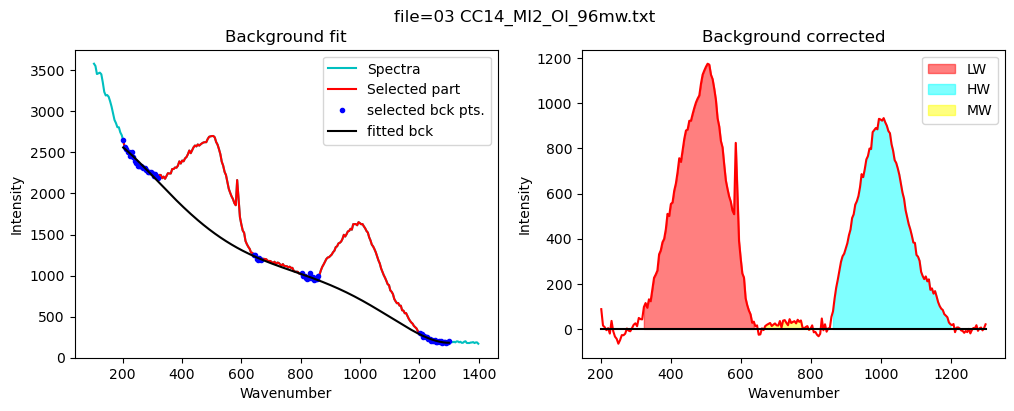

In [17]:

print(config_silicate)
df_sil=pf.fit_area_for_silicate_region(Spectra=Spectra2, 
path=spectra_path, filename=filename_Host, config1=config_silicate, 
 plot_figure=True,
fit_sil='poly')
df_sil

## Now quantify the area under the water region

water_bck_pos(fit_water='poly', N_poly_water=2, lower_bck_water=(2400, 2750), upper_bck_water=(3750, 4100))


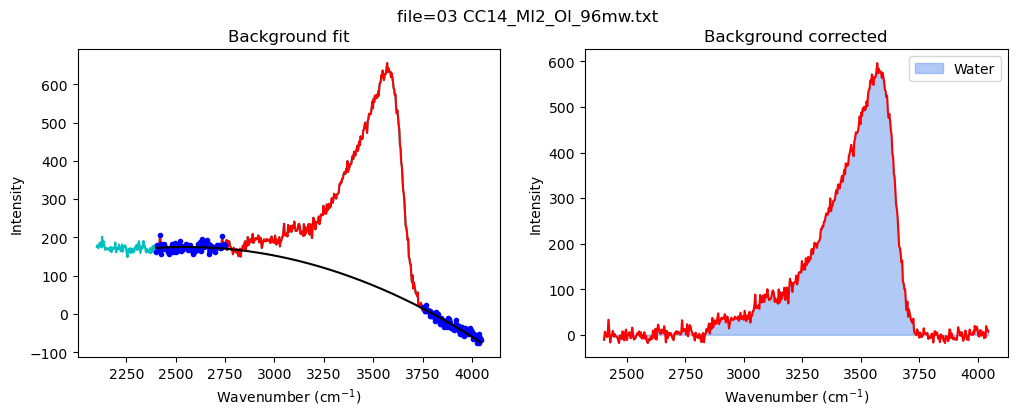

In [18]:
config_MI=pf.water_bck_pos(lower_bck_water=(2400, 2750),
N_poly_water=2)
print(config_MI)
df_MI=pf.fit_area_for_water_region(
path=spectra_path, filename=filename_Host,
Spectra=Spectra2, config1=config_MI, plot_figure=True)

In [19]:
combo_out=pf.stitch_dataframes_together(df_sil=df_sil, df_water=df_MI, 
Host_file=filename_Host, MI_file=filename_MI)
combo_out

,Host filename,MI filename,Water_to_HW_ratio_Trapezoid,Water_to_HW_ratio_Simpson,Water_to_Total_Silicate_ratio_Trapezoid,Water_to_Total_Silicate_ratio_Simpson,Water_Trapezoid_Area,Water_Simpson_Area,Silicate_Trapezoid_Area,Silicate_Simpson_Area,...,HW_Silicate_Trapezoid_Area,HW_Silicate_Simpson_Area,MW_Silicate_Trapezoid_Area,MW_Silicate_Simpson_Area,Water Filename,Water_LHS_Back1,Water_LHS_Back2,Water_RHS_Back1,Water_RHS_Back2,Water_N_Poly
0,03 CC14_MI2_Ol_96mw.txt,02 CC14_MI2_H2O_96mw.txt,1.29263,1.291034,0.556332,0.556073,211330.717146,211165.80878,379864.496263,379745.013178,...,163488.966895,163563.287063,2856.492903,2889.766264,03 CC14_MI2_Ol_96mw.txt,2400,2750,3750,4100,2


## Now we have set it up for one melt inclusion host pair, we can use the same parameters to loop through all files

100%|██████████| 9/9 [00:06<00:00,  1.40it/s]


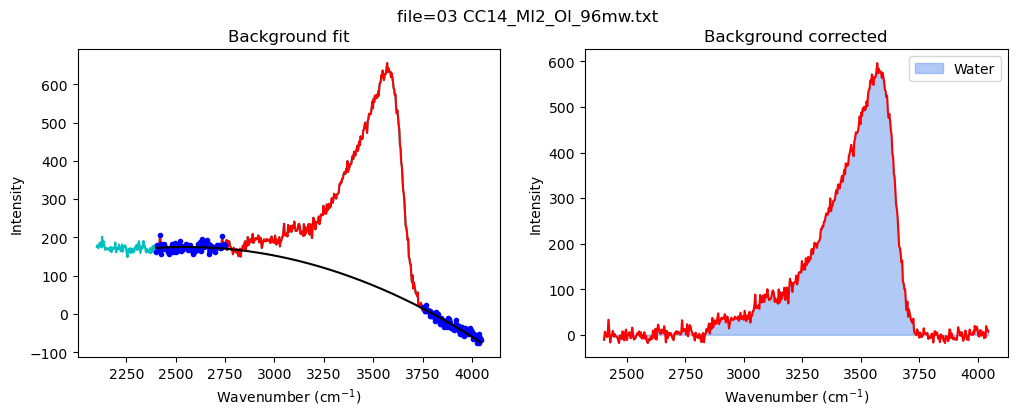

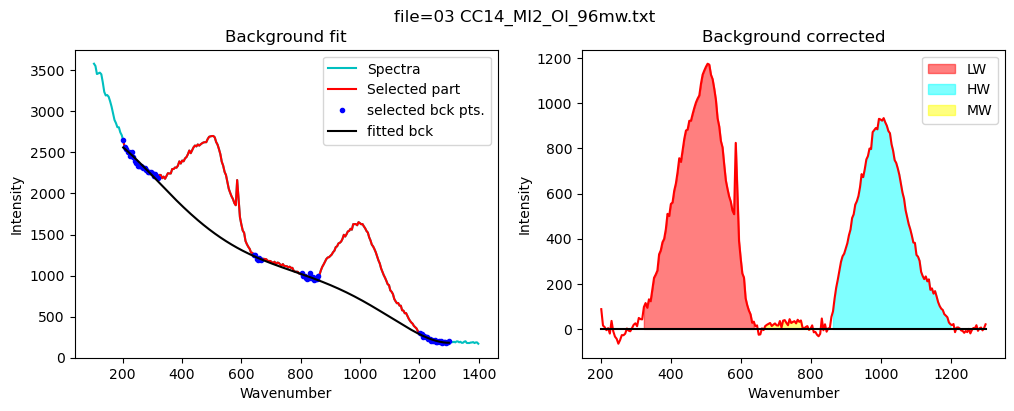

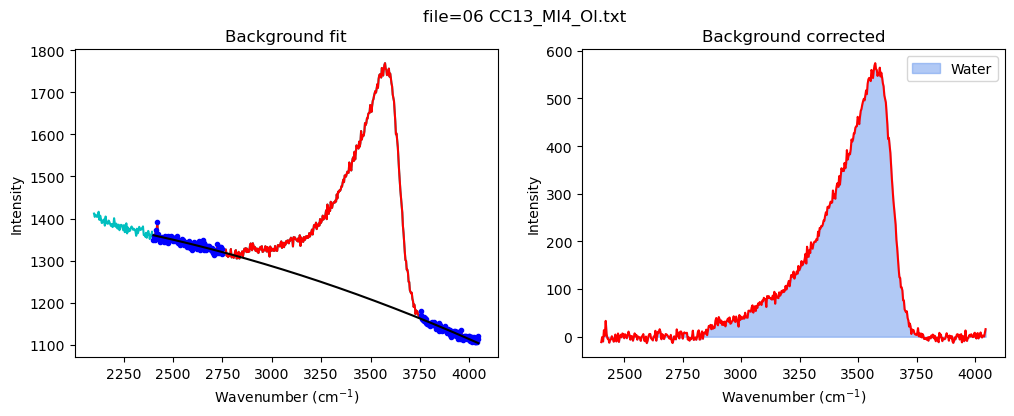

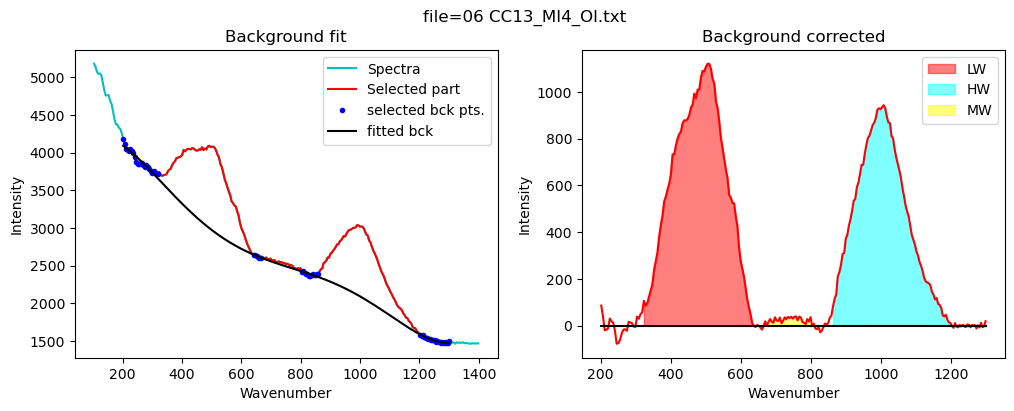

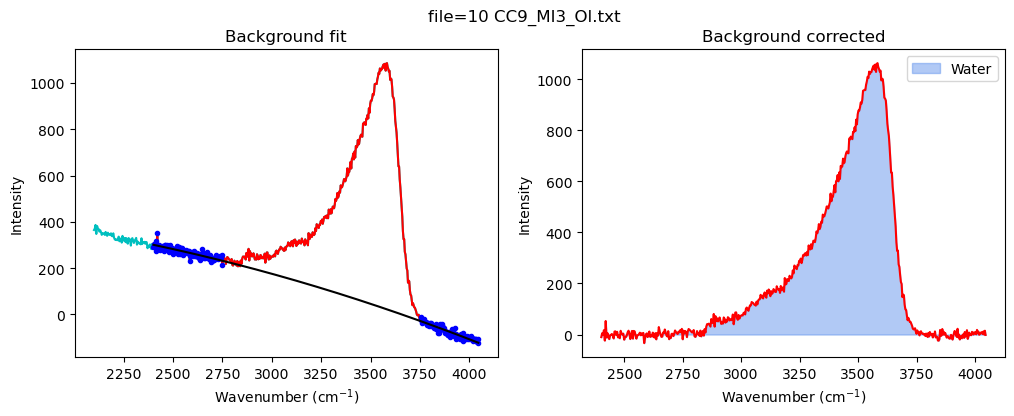

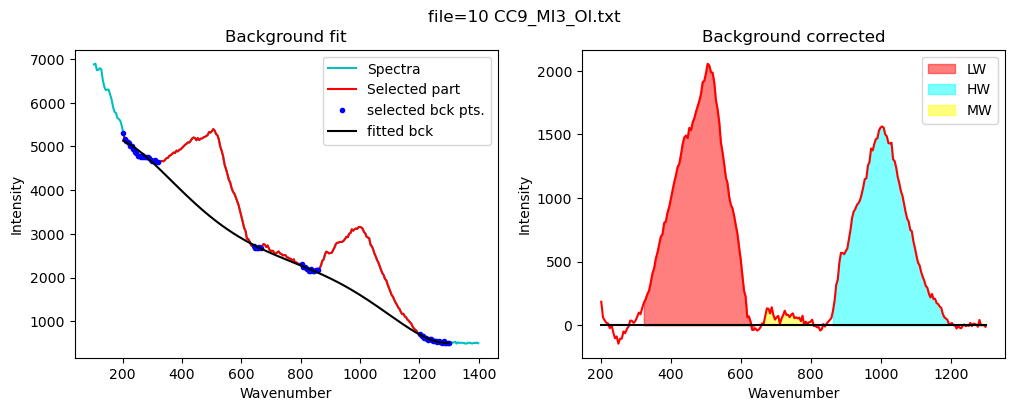

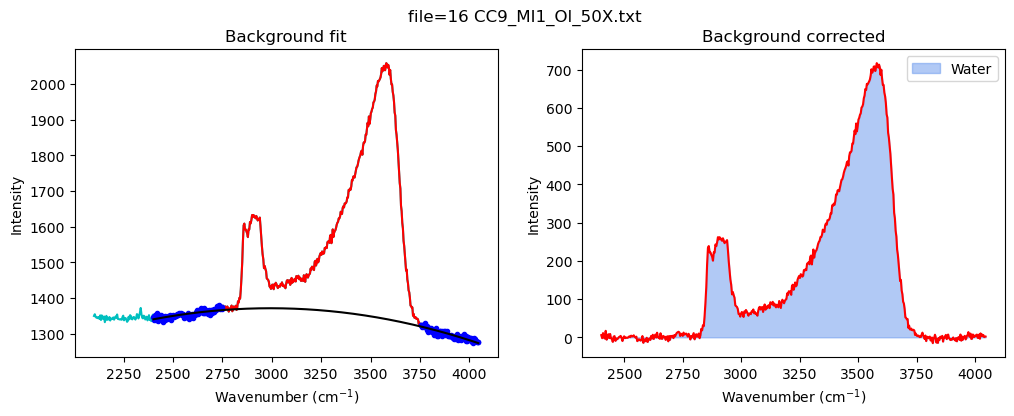

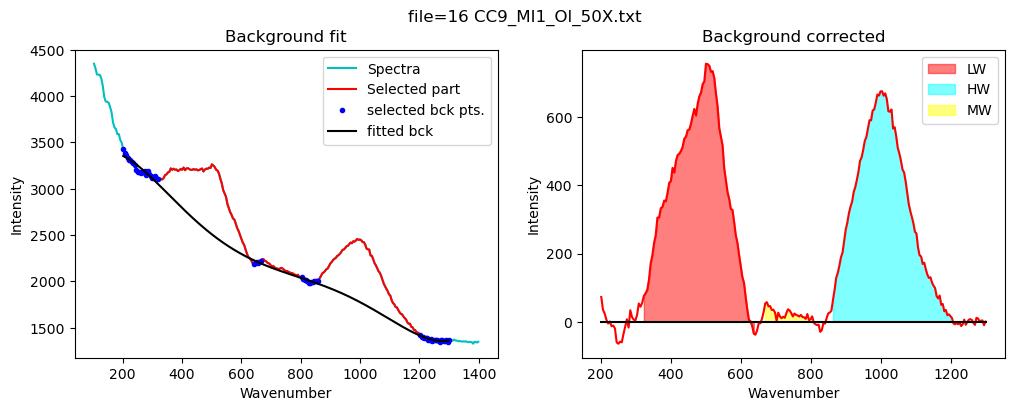

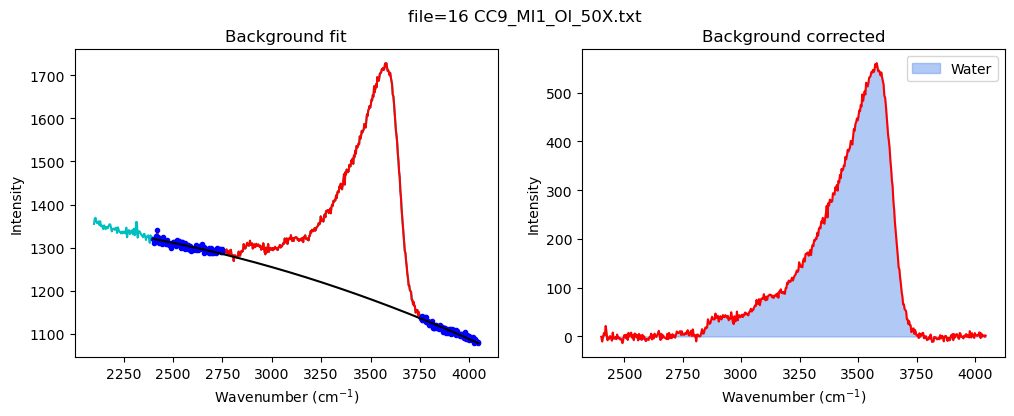

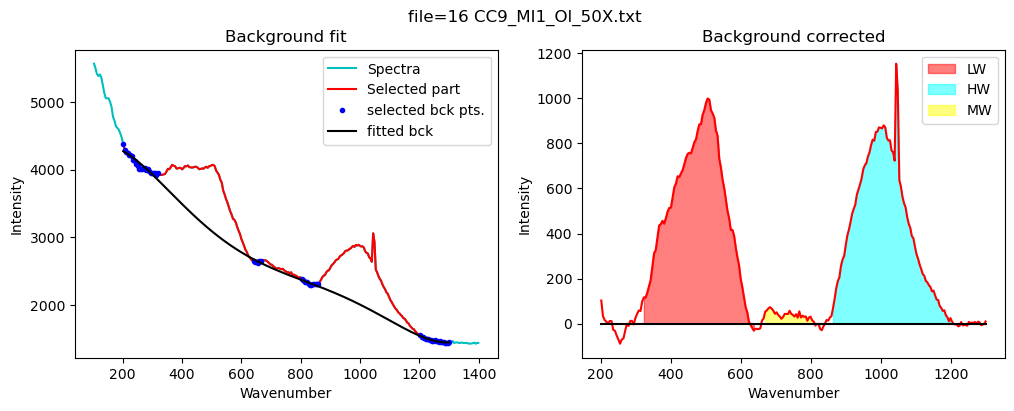

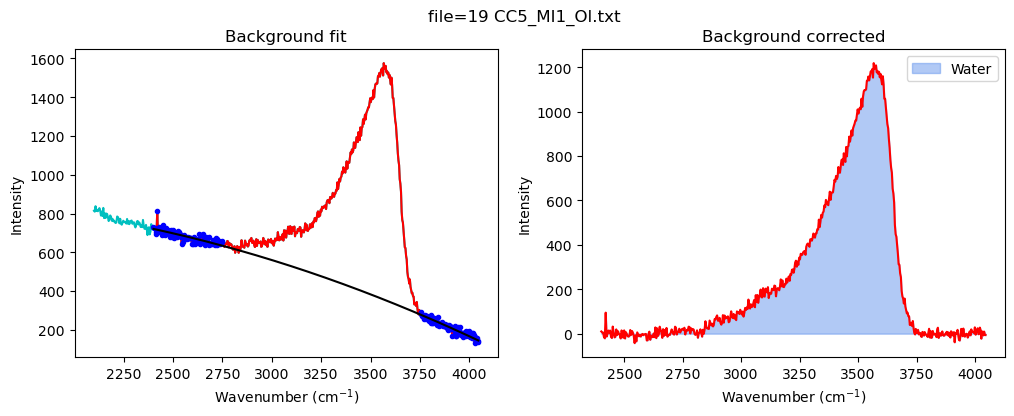

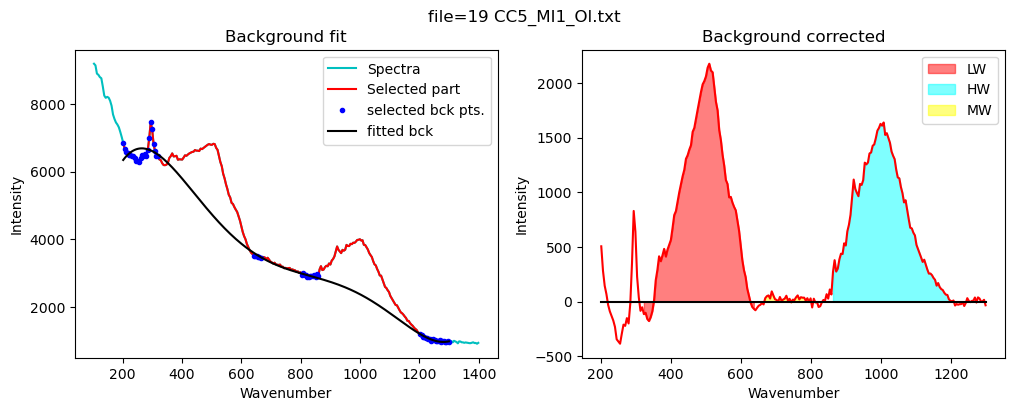

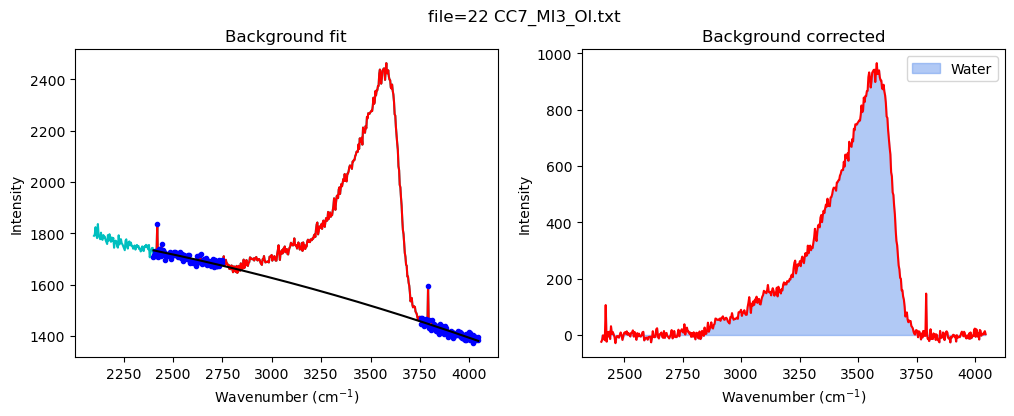

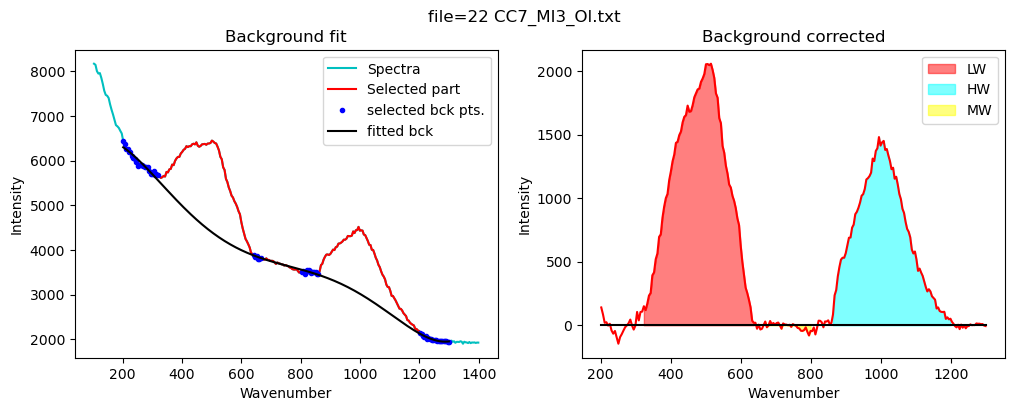

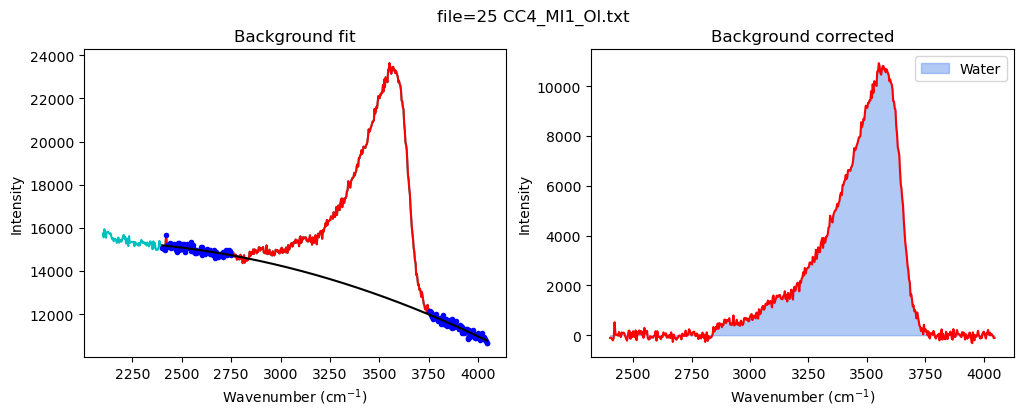

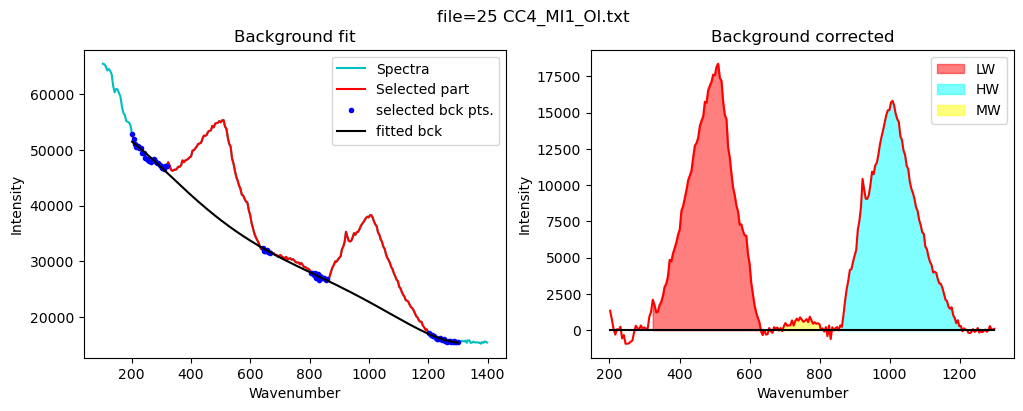

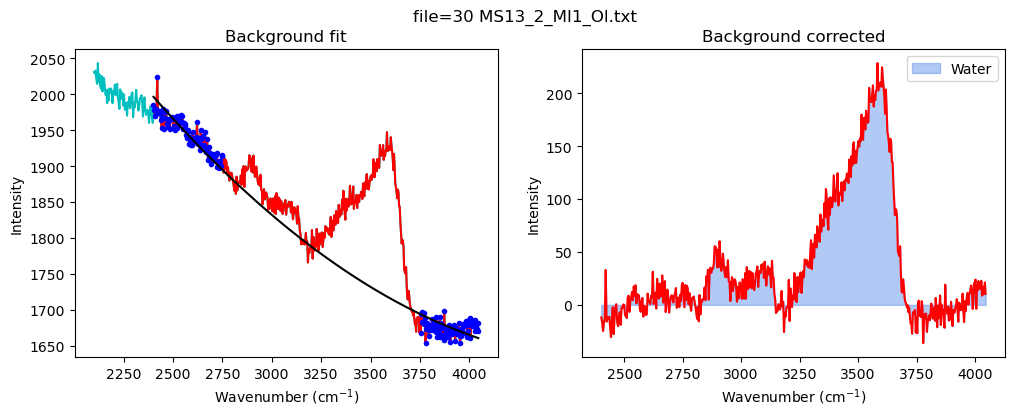

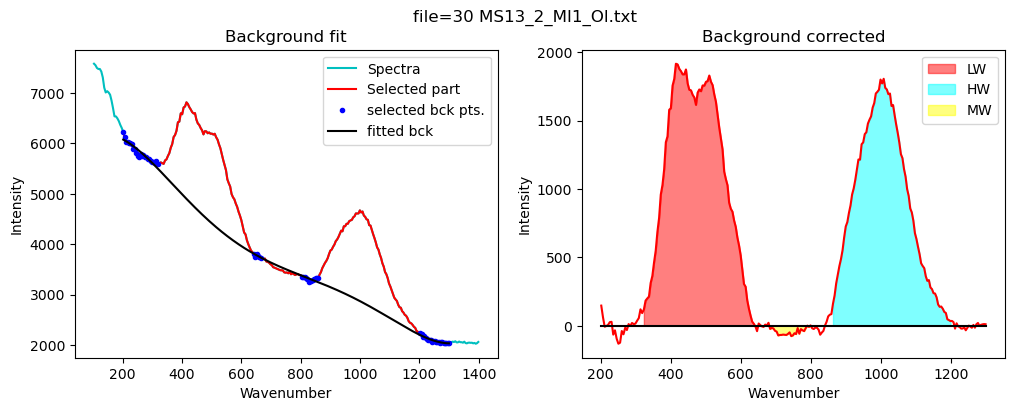

In [20]:
## Now lets loop through all files
from tqdm import tqdm

df_merged=pd.DataFrame([])
for i in tqdm(range(0, len(merge))):
    filename_MI=merge['filename_x'].iloc[i]
    filename_Host=merge['filename_y'].iloc[i]

    
    # Get files
    spectra_Host=pf.get_data(path=spectra_path, filename=filename_Host,
            Diad_files=None, filetype=filetype)

    spectra_MI=pf.get_data(path=spectra_path, filename=filename_MI,
            Diad_files=None, filetype=filetype)
    
    # Smooth spectra
    x_new, y_cub_MI, y_cub_Host, peak_pos_Host, peak_height_Host, trough_x, trough_y=pf.smooth_and_trim_around_host(
    x_range=[800,900], x_max=900, Host_spectra=spectra_Host,
    MI_spectra=spectra_MI, filename=filename_Host, plot_figure=False)

    # Get best fit mixing proportions
    MI_Mix_Best, ideal_mix, Dist, MI_Mix, X=pf.make_evaluate_mixed_spectra(
    path=spectra_path, filename=filename_Host,
    smoothed_host_y=y_cub_Host, smoothed_MI_y=y_cub_MI,
    Host_spectra=spectra_Host, MI_spectra=spectra_MI, x_new=x_new, 
    peak_pos_Host= peak_pos_Host,
    trough_x=trough_x, trough_y=trough_y, N_steps=20, av_width=2,
    X_min=0, X_max=2, plot_figure=False)


    Spectra2=pf.check_if_spectra_negative(Spectra=MI_Mix_Best, 
    path=spectra_path, filename=filename_Host,
    peak_pos_Host=peak_pos_Host, tie_x_cord=2000, 
    override=False, flip=True, plot_figure=False)    

    # Fit water
    df_H2O=pf.fit_area_for_water_region(
    path=spectra_path, filename=filename_Host,
    Spectra=Spectra2, config1=config_MI, plot_figure=True)
    
    # Fit silica spectra
    df_sil=pf.fit_area_for_silicate_region(Spectra=Spectra2, 
    path=spectra_path, filename=filename_Host, config1=config_silicate, 
     plot_figure=True,
    fit_sil='poly')
    
    data=pf.stitch_dataframes_together(df_sil=df_sil, 
        df_water=df_H2O, 
Host_file=filename_Host, MI_file=filename_MI)
    
    df_merged = pd.concat([df_merged, data], axis=0)
                          
df_merged=df_merged.reset_index(drop=True)

In [21]:
# You can inspect the results here
df_merged.head()

,Host filename,MI filename,Water_to_HW_ratio_Trapezoid,Water_to_HW_ratio_Simpson,Water_to_Total_Silicate_ratio_Trapezoid,Water_to_Total_Silicate_ratio_Simpson,Water_Trapezoid_Area,Water_Simpson_Area,Silicate_Trapezoid_Area,Silicate_Simpson_Area,...,HW_Silicate_Trapezoid_Area,HW_Silicate_Simpson_Area,MW_Silicate_Trapezoid_Area,MW_Silicate_Simpson_Area,Water Filename,Water_LHS_Back1,Water_LHS_Back2,Water_RHS_Back1,Water_RHS_Back2,Water_N_Poly
0,03 CC14_MI2_Ol_96mw.txt,02 CC14_MI2_H2O_96mw.txt,1.292630,1.291034,0.556332,0.556073,211330.717146,211165.808780,379864.496263,379745.013178,...,163488.966895,163563.287063,2856.492903,2889.766264,03 CC14_MI2_Ol_96mw.txt,2400,2750,3750,4100,2
1,06 CC13_MI4_Ol.txt,05 CC13_MI4_H2O.txt,1.273932,1.275060,0.540900,0.540831,204905.623402,204953.099115,378823.385237,378959.477396,...,160845.062379,160739.920557,3243.413314,3171.252208,06 CC13_MI4_Ol.txt,2400,2750,3750,4100,2
2,10 CC9_MI3_Ol.txt,09 CC9_MI3_H2O.txt,1.462606,1.464274,0.608228,0.609066,390345.883604,390493.015370,641775.587932,641133.969309,...,266883.839787,266680.342116,8678.840041,8710.813827,10 CC9_MI3_Ol.txt,2400,2750,3750,4100,2
3,16 CC9_MI1_Ol_50X.txt,12 CC9_MI1_H2O_20X.txt,2.295836,2.294857,1.036495,1.036426,271652.008729,271618.716229,262087.178060,262072.519289,...,118323.771655,118359.740987,3076.166398,3017.302181,16 CC9_MI1_Ol_50X.txt,2400,2750,3750,4100,2
4,16 CC9_MI1_Ol_50X.txt,15 CC9_MI1_H2O_50X.txt,1.290089,1.291685,0.585702,0.586346,203547.742283,203697.502551,347528.113007,347401.545257,...,157778.011672,157699.085679,5423.488225,5568.872826,16 CC9_MI1_Ol_50X.txt,2400,2750,3750,4100,2


In [22]:
# And save them to Excel here
df_merged.to_excel('H2O_Silicate_areas.xlsx')